---
# Assigment 1

Name: DUONG SON THONG

Student Number: 223593948

Email: s223593948@deakin.edu.au

Postgraduate (SIT744)

---

## Introduction

Data link: https://www.kaggle.com/datasets/nanditapore/healthcare-diabetes


The Diabetes Prediction Dataset is a useful resource for researchers, data scientists, and healthcare professionals working on diabetes risk prediction. It contains a range of important health-related features that were carefully collected to support the development of deep learning models. These models can help identify individuals who may be at risk of developing diabetes, supporting efforts in early detection and more effective treatment planning.

# Describe the dataset

This dataset comprises medical diagnostic measurements for **2,768 samples**, primarily used for predictive modeling of diabetes. It contains **10 columns**, each representing patient attributes or outcomes related to diabetes diagnostics.

**Variables**

| Variable Name | Label                             |
|---------------------|-------------------------------------------------|
| Pregnancies         | Number of times the individual has been pregnant|
| Glucose             | Plasma glucose concentration (mg/dL)            |
| BloodPressure       | Diastolic blood pressure (mm Hg)                |
| SkinThickness       | Triceps skinfold thickness (mm)                 |
| Insulin             | 2-Hour serum insulin (mu U/ml).                 |
| BMI                 | Body mass index (weight in kg/(height in m)^2)  |
| DiabetesPedigreeFunction      | A function representing diabetes likelihood based on family history          |
| Age                 | Age of the individual (years)  |
| Outcome                 | Binary indicator of diabetes presence (1 = diabetic, 0 = non-diabetic)  |
| Id                 | Unique identifier for each record.  |

**Import package**

In [12]:
import torch
from torch import nn
import pandas as pd
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch.utils.tensorboard import SummaryWriter
import time


## **Set 1 Build a Simple Neural Network (P-Level Tasks)**

### **1. Define the Machine Learning Problem**

**Problem Title:** *Predicting Diabetes Diagnosis Using Neural Networks*

#### a. Problem Description

This project uses a dataset containing medical diagnostic measurements from female patients to predict the presence of diabetes. The task is a **binary classification** problem, where the goal is to determine whether a patient has diabetes (Outcome = 1) or not (Outcome = 0) based on various features such as glucose level, BMI, age, and more. Neural networks are well-suited for this task due to their ability to model complex, nonlinear relationships between health indicators.

#### b. Objectives

* Develop a neural network that can accurately classify whether a patient has diabetes.
* Evaluate model performance using appropriate metrics.
* Explore hyperparameter tuning and architecture optimization to improve model performance.

#### c. Potential Ethical Concerns and Dataset Biases

* **Dataset Bias – Gender Limitation:**
  The dataset contains only female patients, which introduces **gender bias**. As a result, the trained model may not generalize well to male patients or populations with different demographics.

* **Privacy and Security:**
  Since the dataset involves sensitive medical information, it is essential to **ensure patient anonymity** and comply with privacy laws such as **HIPAA** (Health Insurance Portability and Accountability Act) or **GDPR** (General Data Protection Regulation). Any data handling or sharing should prioritize ethical standards for data protection.

* **Model Explainability:**
  Neural networks are often considered **black-box** models. This lack of transparency can be a barrier in clinical environments where interpretability is critical. Incorporating **explainable AI (XAI)** techniques, such as SHAP or LIME, may improve trust and usability among healthcare professionals.



### **2. Dataset Selection and Justification**

#### Selected Dataset
The dataset consists of medical information from **2,768 patients**, including features like **glucose level**, **blood pressure**, **BMI**, and a binary **Outcome** indicating the presence (`1`) or absence (`0`) of diabetes.

---

#### Justification of Suitability

- **Size:**  
  With 2,768 entries, the dataset is reasonably sized for training a neural network without requiring excessive computational resources. While not "big data," it offers a solid foundation for supervised learning.

- **Complexity:**  
  The dataset includes a mix of **demographic** (e.g., age, pregnancies) and **physiological** (e.g., glucose, insulin) features. This complexity is well-suited for neural networks, which can model nonlinear interactions between variables.

- **Relevance:**  
  All features are medically relevant to diabetes prediction, aligning well with the classification objective.

---

#### Bias Considerations

- **Zero values in medical fields** (e.g., Insulin, Glucose, BloodPressure) likely indicate missing or unrecorded data, which can introduce bias if not handled properly.

- **Demographic scope is unclear**, as there is no gender or ethnicity column. This makes it hard to assess generalizability across populations.


#### Process Data

In [13]:
datasetCsv = pd.read_csv('dataset.csv')
datasetCsv.head()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


##### Process Data Steps (The steps below reference the unit SIT731-Data wrangling):
- Drop the Id column (not predictive).

- Replace zero values in physiological fields with NaN.

- Impute missing values using median (robust against outliers).

- Normalize numerical features (neural networks benefit from scaled inputs).

- Separate features and labels

In [14]:
# drop id column because it can't be a feature to train
datasetCsv.drop(columns=["Id"], axis= 1, inplace=True)
#replace zeros with NaN 
fields_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in fields_with_invalid_zeros:
    datasetCsv[col] = datasetCsv[col].apply(lambda x: np.nan if x == 0 else x)

#impute values
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(datasetCsv), columns=datasetCsv.columns)

#normalize feature columns (excluding the target)
X = df_imputed.drop(columns=['Outcome'])
y = df_imputed['Outcome']
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#use SMOTE to balance data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
#combine features and label into one DataFrame

preprocessed_df = X_resampled.copy()
preprocessed_df['Outcome'] = y_resampled

preprocessed_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.679232,0.856993,-0.032190,0.641606,-0.177015,0.141662,0.478509,1.432495,1.0
1,-0.825341,-1.208717,-0.532758,-0.022803,-0.177015,-0.843952,-0.369130,-0.181079,0.0
2,1.281062,2.004610,-0.699614,-0.022803,-0.177015,-1.308598,0.616712,-0.096154,1.0
3,-0.825341,-1.077561,-0.532758,-0.687212,-0.563148,-0.632749,-0.934224,-1.030329,0.0
4,-1.126256,0.496313,-2.701886,0.641606,0.329784,1.479279,5.579704,-0.011229,1.0


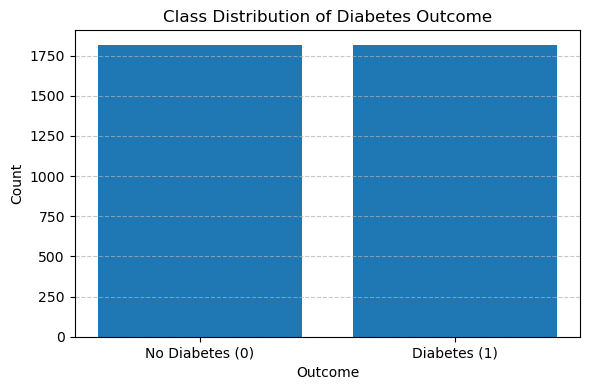

In [15]:
import matplotlib.pyplot as plt


# Plot bar chart for class distribution
outcome_counts = preprocessed_df['Outcome'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(outcome_counts.index.astype(str), outcome_counts.values)
plt.title('Class Distribution of Diabetes Outcome')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 3. Define a simple fully connected neural network using PyTorch.

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

### 4. Implement the training pipeline. Train the model and evaluate its performance on test data.

In [17]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
writer = SummaryWriter(log_dir=f"runs/experiment_{int(time.time())}")
class CustomDataset(Dataset):
    def __init__(self, dataFrane):
        self.data = dataFrane
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        features = torch.tensor(row[:-1].values, dtype=torch.float32)
        label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]
        return features, label

def train(dataLoader, model, loss_fn, optimizer, epoch, writer):
        size = len(dataLoader.dataset)
        model.train() #set model to the training mode, it just switches internal setting
        running_loss = 0.0
        correct = 0
        for batch, (X, y) in enumerate(dataLoader):
            X, y = X.to(device), y.to(device)
            predict = model(X)
            loss = loss_fn(predict, y)
            #backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() #?
            # Calculate accuracy for this batch
            pred_binary = (predict >= 0.5).float()
            correct += (pred_binary == y).sum().item()
            running_loss += loss.item()
            
            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # Log training metrics to TensorBoard
        avg_loss = running_loss / len(dataLoader)
        accuracy = (correct / size) * 100
        
        writer.add_scalar('Loss/Train', avg_loss, epoch)
        writer.add_scalar('Accuracy/Train', accuracy, epoch)
                
def test(dataloader, model, loss_fn, epoch, writer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = pred.flatten()
            y = y.flatten()
            for i in range(len(pred)):
                predict = 1 if pred[i] >= 0.5 else 0
                if predict == y[i]:
                   correct += 1 
    test_loss /= num_batches
    correct /= size
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', correct, epoch)
    print(f"Accuracy: {correct}%, Avg loss: {test_loss:>8f} \n")
    
customDataset = CustomDataset(preprocessed_df)

trainData, testData = random_split(customDataset, [0.8, 0.2])
print(len(trainData))
print(len(testData))
trainDataLoader = DataLoader(trainData, batch_size=64, shuffle=True)
testDataLoader = DataLoader(testData, batch_size=64, shuffle=False)
model = NeuralNetwork().to(device)
loss_fn = nn.BCELoss() # use binary cross entropy because we have 2 classes in target
optimizer = torch.optim.SGD(model.parameters(), lr= 0.01) #??? changed SGD to adam

epochs = 20
for i in range(epochs):
    print(f'Epoch {i + 1}')
    train(trainDataLoader, model, loss_fn, optimizer, i, writer)
    test(testDataLoader, model, loss_fn, i, writer)
writer.close()
print("DONE!")


2906
726
Epoch 1
loss: 0.720306  [   64/ 2906]


/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_1346/118261623.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


Accuracy: 0.5068870523415978%, Avg loss: 0.691698 

Epoch 2
loss: 0.699499  [   64/ 2906]
Accuracy: 0.6005509641873278%, Avg loss: 0.672997 

Epoch 3
loss: 0.664159  [   64/ 2906]
Accuracy: 0.6639118457300276%, Avg loss: 0.656645 

Epoch 4
loss: 0.659223  [   64/ 2906]
Accuracy: 0.6776859504132231%, Avg loss: 0.641982 

Epoch 5
loss: 0.631977  [   64/ 2906]
Accuracy: 0.6900826446280992%, Avg loss: 0.628367 

Epoch 6
loss: 0.619806  [   64/ 2906]
Accuracy: 0.7024793388429752%, Avg loss: 0.615732 

Epoch 7
loss: 0.620651  [   64/ 2906]
Accuracy: 0.7148760330578512%, Avg loss: 0.603808 

Epoch 8
loss: 0.607655  [   64/ 2906]
Accuracy: 0.7258953168044077%, Avg loss: 0.592781 

Epoch 9
loss: 0.602362  [   64/ 2906]
Accuracy: 0.7286501377410468%, Avg loss: 0.582517 

Epoch 10
loss: 0.563356  [   64/ 2906]
Accuracy: 0.7369146005509641%, Avg loss: 0.573150 

Epoch 11
loss: 0.544690  [   64/ 2906]
Accuracy: 0.7382920110192838%, Avg loss: 0.564441 

Epoch 12
loss: 0.552026  [   64/ 2906]
Accurac

## **Set 2: Improve Model Performance (C-Level Tasks)**

### 1. Use TensorBoard to log loss and accuracy.

In [20]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5161), started 0:05:58 ago. (Use '!kill 5161' to kill it.)

### 2. Modify the network architecture to improve performance.

- Change optimizer from SGD to Adam
- Reduce the learning rate from 0.01 to 0.001

In [19]:
writer = SummaryWriter(log_dir=f"runs/experiment_{int(time.time())}")
batch_size = 32
trainDataLoader = DataLoader(trainData, batch_size = batch_size, shuffle=True)
testDataLoader = DataLoader(testData, batch_size = batch_size, shuffle=False)
model = NeuralNetwork().to(device)
loss_fn = nn.BCELoss() # use binary cross entropy because we have 2 classes in target
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001) #??? changed SGD to adam

epochs = 20
for i in range(epochs):
    print(f'Epoch {i + 1}')
    train(trainDataLoader, model, loss_fn, optimizer, i, writer)
    test(testDataLoader, model, loss_fn, i, writer)
writer.close()
print("DONE!")

Epoch 1
loss: 0.662000  [   32/ 2906]


/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_1346/118261623.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


Accuracy: 0.7534435261707989%, Avg loss: 0.558151 

Epoch 2
loss: 0.578132  [   32/ 2906]
Accuracy: 0.7644628099173554%, Avg loss: 0.499898 

Epoch 3
loss: 0.401897  [   32/ 2906]
Accuracy: 0.7644628099173554%, Avg loss: 0.477558 

Epoch 4
loss: 0.466361  [   32/ 2906]
Accuracy: 0.7851239669421488%, Avg loss: 0.466639 

Epoch 5
loss: 0.434825  [   32/ 2906]
Accuracy: 0.7851239669421488%, Avg loss: 0.460435 

Epoch 6
loss: 0.449662  [   32/ 2906]
Accuracy: 0.7823691460055097%, Avg loss: 0.457136 

Epoch 7
loss: 0.334838  [   32/ 2906]
Accuracy: 0.7878787878787878%, Avg loss: 0.454830 

Epoch 8
loss: 0.483561  [   32/ 2906]
Accuracy: 0.7961432506887053%, Avg loss: 0.451416 

Epoch 9
loss: 0.390999  [   32/ 2906]
Accuracy: 0.7961432506887053%, Avg loss: 0.449660 

Epoch 10
loss: 0.337467  [   32/ 2906]
Accuracy: 0.7988980716253443%, Avg loss: 0.447647 

Epoch 11
loss: 0.360873  [   32/ 2906]
Accuracy: 0.803030303030303%, Avg loss: 0.446166 

Epoch 12
loss: 0.491008  [   32/ 2906]
Accuracy